In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


#Problem Statement and EDA
This Kaggle contest is about using NLP to classify tweets as either referring to real disasters or referring to benign events. Natural language processing (NLP), broadly speaking, is a technology that allows computers to understand and interpret human language. Words and sentences can be converted into numerical representations, and we can use neural networks to learn their meaning. Emergency responders and relief services are interested in this problem because posts on Twitter could be one of the quickest ways to learn about natural disasters as they unfold in real time, especially as more and more people have access to smartphones. However, tweets are short blips of information, and language can be tricky sometimes. The exact same words used to describe a real fire could be speaking metaphorically about something completely benign, like someone's emotions. We are given a set of about 10,000 tweets that have been hand-labeled to train our models and help them learn the subtle difference between these types of tweets.

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

nlp_getting_started_path = kagglehub.competition_download('nlp-getting-started')
soccerguy282_1_epoch_electra_pytorch_default_1_path = kagglehub.model_download('soccerguy282/1-epoch-electra/PyTorch/default/1')
soccerguy282_electra_5_epoch_pytorch_electra_5_epoch_1_path = kagglehub.model_download('soccerguy282/electra-5-epoch/PyTorch/electra-5-epoch/1')
soccerguy282_electra_12_epochs_pytorch_default_1_path = kagglehub.model_download('soccerguy282/electra-12-epochs/PyTorch/default/1')

print('Data source import complete.')


In [ ]:
# Importing the libraries needed
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import ElectraForSequenceClassification, ElectraTokenizer, ElectraConfig, AutoModelForSequenceClassification
import logging
logging.basicConfig(level=logging.ERROR)
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from huggingface_hub import hf_hub_download, snapshot_download
from transformers import AutoModelForSequenceClassification

Let's check to see if the GPU is, in fact, enabled.

In [ ]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

Great we have a GPU (Tesla P100 in this case) with cuda enabled. Let's load in and take a look at the training data.

In [ ]:
datapath = nlp_getting_started_path
modelpath = soccerguy282_electra_12_epochs_pytorch_default_1_path
traindataorig = pd.read_csv(datapath + '/train.csv')

traindataorig.head()

Okay so we have a couple of columns that won't be useful for our analysis. Keyword and location are going to be dropped as we are only interested in analysing the text of the tweets to make the decision of disaster or not.

In [ ]:
traindata = traindataorig.drop(['keyword', 'location'], axis=1)
print(traindata.head())
print('Labels present in training data: ', traindata['target'].unique())
print(traindata.describe())
print(traindata.info())
print('Shape of the data', traindata.shape)

In [ ]:
#Checking the distribution of classes
counts = traindata['target'].value_counts()
print(counts)
sns.barplot(x=counts.index, y=counts.values)
plt.xlabel('Label')
plt.ylabel('Number of Observations')
plt.title('Distribution of Labels in the Training Data')
plt.xticks(ticks=[0, 1], labels=['0: No Disaster', '1: Real Disaster'])
plt.show()

This is looking good for our training data, we will have 7,613 training examples and no null or missing values to worry about. This is great because this isn't a very large dataset to begin with. It looks like the distribution of the training data labels is close to 50/50 since the mean of labels in the training set is 0.42966. There is a slight bias towards the 0, or no disaster, label but not enough that we need to worry about it. The shape of our training data is (7613, 3) which represents our 7613 examples, the text of the tweets, and their label as disaster or no disaster. Note that the text is going to go through a preprocessing function, which will turn the text into vectors (numerical representations of their meaning). The length of these vectors will be the number of features that our networks will operate on to decide whether tweets are about real natural disasters or not.

In [ ]:
#Checking a few tweets and their labels
random_samples = np.random.randint(1, len(traindata) + 1, size=15)
for i in random_samples:
    print('###############################################')
    print('Label: ', traindata['target'][i])
    print('Tweet: ', traindata['text'][i])
    print('###############################################')

Looking at some random tweets, it looks like this is going to be a difficult contest, tweets can be very short and have virtually no context, which makes determining if they are referring to an actual disaster very difficult for me as a human. It will be interesting to inspect the false positives from our model. Let's move on and check our testing data that will be submitted to the leaderboard.

In [ ]:
testdata = pd.read_csv(datapath + '/test.csv')
testdata.head()

Again, let's remove keyword and location.

In [ ]:
testdata = testdata.drop(['keyword', 'location'], axis=1)
testdata.head()

In [ ]:
testdata.info()

This looks good we will have 3263 examples in our test set and no missing or null values. I'm going to go ahead and split our training data into training and validation sets. I'll take a random 20% of the training data to use for validation. The stratify argument ensures that the distribution of labels in the training set is maintained in this validation set.

In [ ]:
train_df, val_df = train_test_split(traindata, test_size=0.2, stratify=traindata['target'], random_state=1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

#Model Architecture
We have our training, validation, and test data that we need to train our models. Before I construct models, I'm going to define some hyperparameters that could be tuned later to improve performance.

In [ ]:
#Defining some hyperparameters
MAX_LEN = 512
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
NUM_CLASSES = 1
EPOCHS = 12
LEARNING_RATE = 1e-05

The first model we will look at is Electra. It is a pretrained transformer trained on a large corpus of 1.6 million tweets classifying them into 8 different emotions. We'll take this model and change the number of classes to 1 for this problem (disaster or no disaster).

In [ ]:
# Download the specific tokenizer files
vocab_file = hf_hub_download("bhadresh-savani/electra-base-emotion", "vocab.txt")
tokenizer_config = hf_hub_download("bhadresh-savani/electra-base-emotion", "tokenizer_config.json")
special_tokens_map = hf_hub_download("bhadresh-savani/electra-base-emotion", "special_tokens_map.json")

print(f"Vocab file: {vocab_file}")
print(f"Config file: {tokenizer_config}")
print(f"Special tokens: {special_tokens_map}")

# Create tokenizer manually
tokenizer = ElectraTokenizer(
    vocab_file=vocab_file,
    do_lower_case=True,
    unk_token='[UNK]',
    sep_token='[SEP]',
    pad_token='[PAD]',
    cls_token='[CLS]',
    mask_token='[MASK]'
)

print("Tokenizer created successfully!")

class electra_preprocess(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.target
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        cleaned_text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            cleaned_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation = True, # pad_to_max_length=True,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float),
            'raw_text': text
        }

With this class (electra_preprocess) we will:
1. Load and configure a tokenizer for the Electra model trained on emotion data.
2. Define a PyTorch Dataset that preprocesses input text into model-ready features including token IDs, attention masks, and segment IDs, along with their associated labels (no disaster/disaster).

In [ ]:
training_set = electra_preprocess(train_df, tokenizer, MAX_LEN)
validation_set = electra_preprocess(val_df, tokenizer, MAX_LEN)

Now we can define our dataloaders that will feed examples to the network in batches.

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

validation_params = {'batch_size': VALID_BATCH_SIZE,
               'shuffle': False,
               'num_workers': 0
               }
training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **validation_params)

We'll load in the pretrained model.

In [ ]:
# Download full model directory
model_dir = snapshot_download("bhadresh-savani/electra-base-emotion")

# Load and modify config
config_file = hf_hub_download("bhadresh-savani/electra-base-emotion", "config.json")
config = ElectraConfig.from_json_file(config_file)
config.num_labels = NUM_CLASSES
config.problem_type = "single_label_classification"

# Load the model with updated config
model = ElectraForSequenceClassification.from_pretrained(
    model_dir,
    config=config,
    ignore_mismatched_sizes=True
)

print("Model loaded successfully!")

torch.cuda.empty_cache()
model.to(device)

This model converts tweet text into embeddings, processes them through a 12-layer ELECTRA transformer encoder, then uses a small neural classification head to predict whether the tweet refers to a real disaster. I believe that this model will be successful at this task because it combines pretrained language intelligence with strong contextual reasoning, allowing it to distinguish literal disaster reports from metaphorical or unrelated uses of similar words which is the core difficulty of the competition.

Define our loss function and optimizer.

In [ ]:
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

BCEWithLogitsLoss is a binary classification loss that combines a sigmoid activation with binary cross-entropy in one stable function. It compares the model’s raw output score (logit) to the true label (0 or 1) and penalizes incorrect predictions. Adam is an adaptive gradient-based optimization algorithm that updates model weights during training. It adjusts the learning rate individually for each parameter using running estimates of gradients and squared gradients, which often leads to faster and more stable convergence than standard SGD. The lr=LEARNING_RATE controls the step size of updates, we'll start with 0.00001 and adjust if necessary.

We'll use this function to calculate our accuracy performance metric.

In [ ]:
def calculate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

Defining our training function.

In [ ]:
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    show = 100
    move_loss = 0
    move_acc = 0

    model.train()

    for step, data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float)  # float for BCE loss

        outputs = model(ids, mask, token_type_ids)
        logits = outputs.logits.squeeze()  # shape: [batch_size]

        # Ensure shapes match for BCEWithLogitsLoss
        if logits.dim() == 0:
            logits = logits.unsqueeze(0)
            targets = targets.unsqueeze(0)

        loss = loss_function(logits, targets)
        tr_loss += loss.item()
        move_loss += loss.item()

        # Binary predictions: sigmoid + threshold
        preds = (torch.sigmoid(logits) > 0.5).float()
        correct = (preds == targets).sum().item()
        n_correct += correct
        move_acc += correct

        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)

        if step % show == 0:
            loss_step = tr_loss / nb_tr_steps
            move_loss_avg = move_loss / show
            move_acc_avg = move_acc / show
            accu_step = (n_correct * 100) / nb_tr_examples

            print(f"Training Loss per {show} steps: {loss_step:.4f}")
            print(f"Training Accuracy per {show} steps: {accu_step:.2f}%")
            print(f"Loss (last {show} steps): {move_loss_avg:.4f}")
            print(f"Accuracy (last {show} steps): {move_acc_avg:.4f}")

            move_loss = 0
            move_acc = 0

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    epoch_accu = (n_correct * 100) / nb_tr_examples
    print(f"\nEpoch {epoch} Summary:")
    print(f"  Loss: {epoch_loss:.4f}")
    print(f"  Accuracy: {epoch_accu:.2f}%")

    return epoch_loss, epoch_accu


This function for evaluation on the validation set.

In [ ]:
def evaluate():
    model.eval()
    val_loss = 0
    n_correct = 0
    nb_val_steps = 0
    nb_val_examples = 0

    with torch.no_grad():
        for data in tqdm(validation_loader):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)

            outputs = model(ids, mask, token_type_ids)
            logits = outputs.logits.squeeze()

            if logits.dim() == 0:
                logits = logits.unsqueeze(0)
                targets = targets.unsqueeze(0)

            loss = loss_function(logits, targets)
            val_loss += loss.item()

            preds = (torch.sigmoid(logits) > 0.5).float()
            correct = (preds == targets).sum().item()
            n_correct += correct

            nb_val_steps += 1
            nb_val_examples += targets.size(0)

    avg_loss = val_loss / nb_val_steps
    avg_acc = n_correct / nb_val_examples * 100

    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Validation Accuracy: {avg_acc:.2f}%")

    return avg_loss, avg_acc

We're now ready to train the model and it is important that we immediately save the trained network. If something crashes or times out, we can always load it back in without having to perform resource intensive training. In this notebook, I am simply going to load back in my best performing model instead of rerunning any of the actual training in the following cell.

In [ ]:
#Create variables to track loss and accuracy for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(1, 1 + EPOCHS):
    # Run one epoch of training
    train_loss, train_acc = train(epoch)

    # Run validation and get loss & accuracy
    val_loss, val_acc = evaluate()

    # Save metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

print('Model trained')
CaseName = 'Electra_EPOCHS_' + str(EPOCHS)

output_model_file = CaseName + '.bin'
output_vocab_file = './'

model_to_save = model
torch.save(model_to_save, output_model_file)

print('All files saved')

Here is the code to load back in trained models.

In [ ]:
model = torch.load('/root/.cache/kagglehub/models/soccerguy282/electra-12-epochs/PyTorch/default/1/Electra_EPOCHS_12.bin', weights_only=False,
                  map_location=torch.device(device))# Adjust filename as needed
torch.cuda.empty_cache()
model.to(device)  # Move to GPU or CPU
model.eval()      # Set to eval mode if doing inference

# Explicitly set output_attentions and output_hidden_states in the model's config
# This addresses the AttributeError: 'ElectraConfig' object has no attribute '_output_attentions'
if not hasattr(model.config, 'output_attentions'):
    model.config.output_attentions = False
if not hasattr(model.config, 'output_hidden_states'):
    model.config.output_hidden_states = False

print("Model loaded successfully and config attributes checked.")

#Results and Analysis
To tune this model, I tried training for 5, 8, 12, and 20 epochs. Let's plot the loss and accuracy to see if we are converging.

In [ ]:
epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, val_losses, label="Val Loss", marker='o')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Acc", marker='o')
plt.plot(epochs, val_accuracies, label="Val Acc", marker='o')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(f"training_metrics_electra_{EPOCHS}epochs.png", dpi=300)



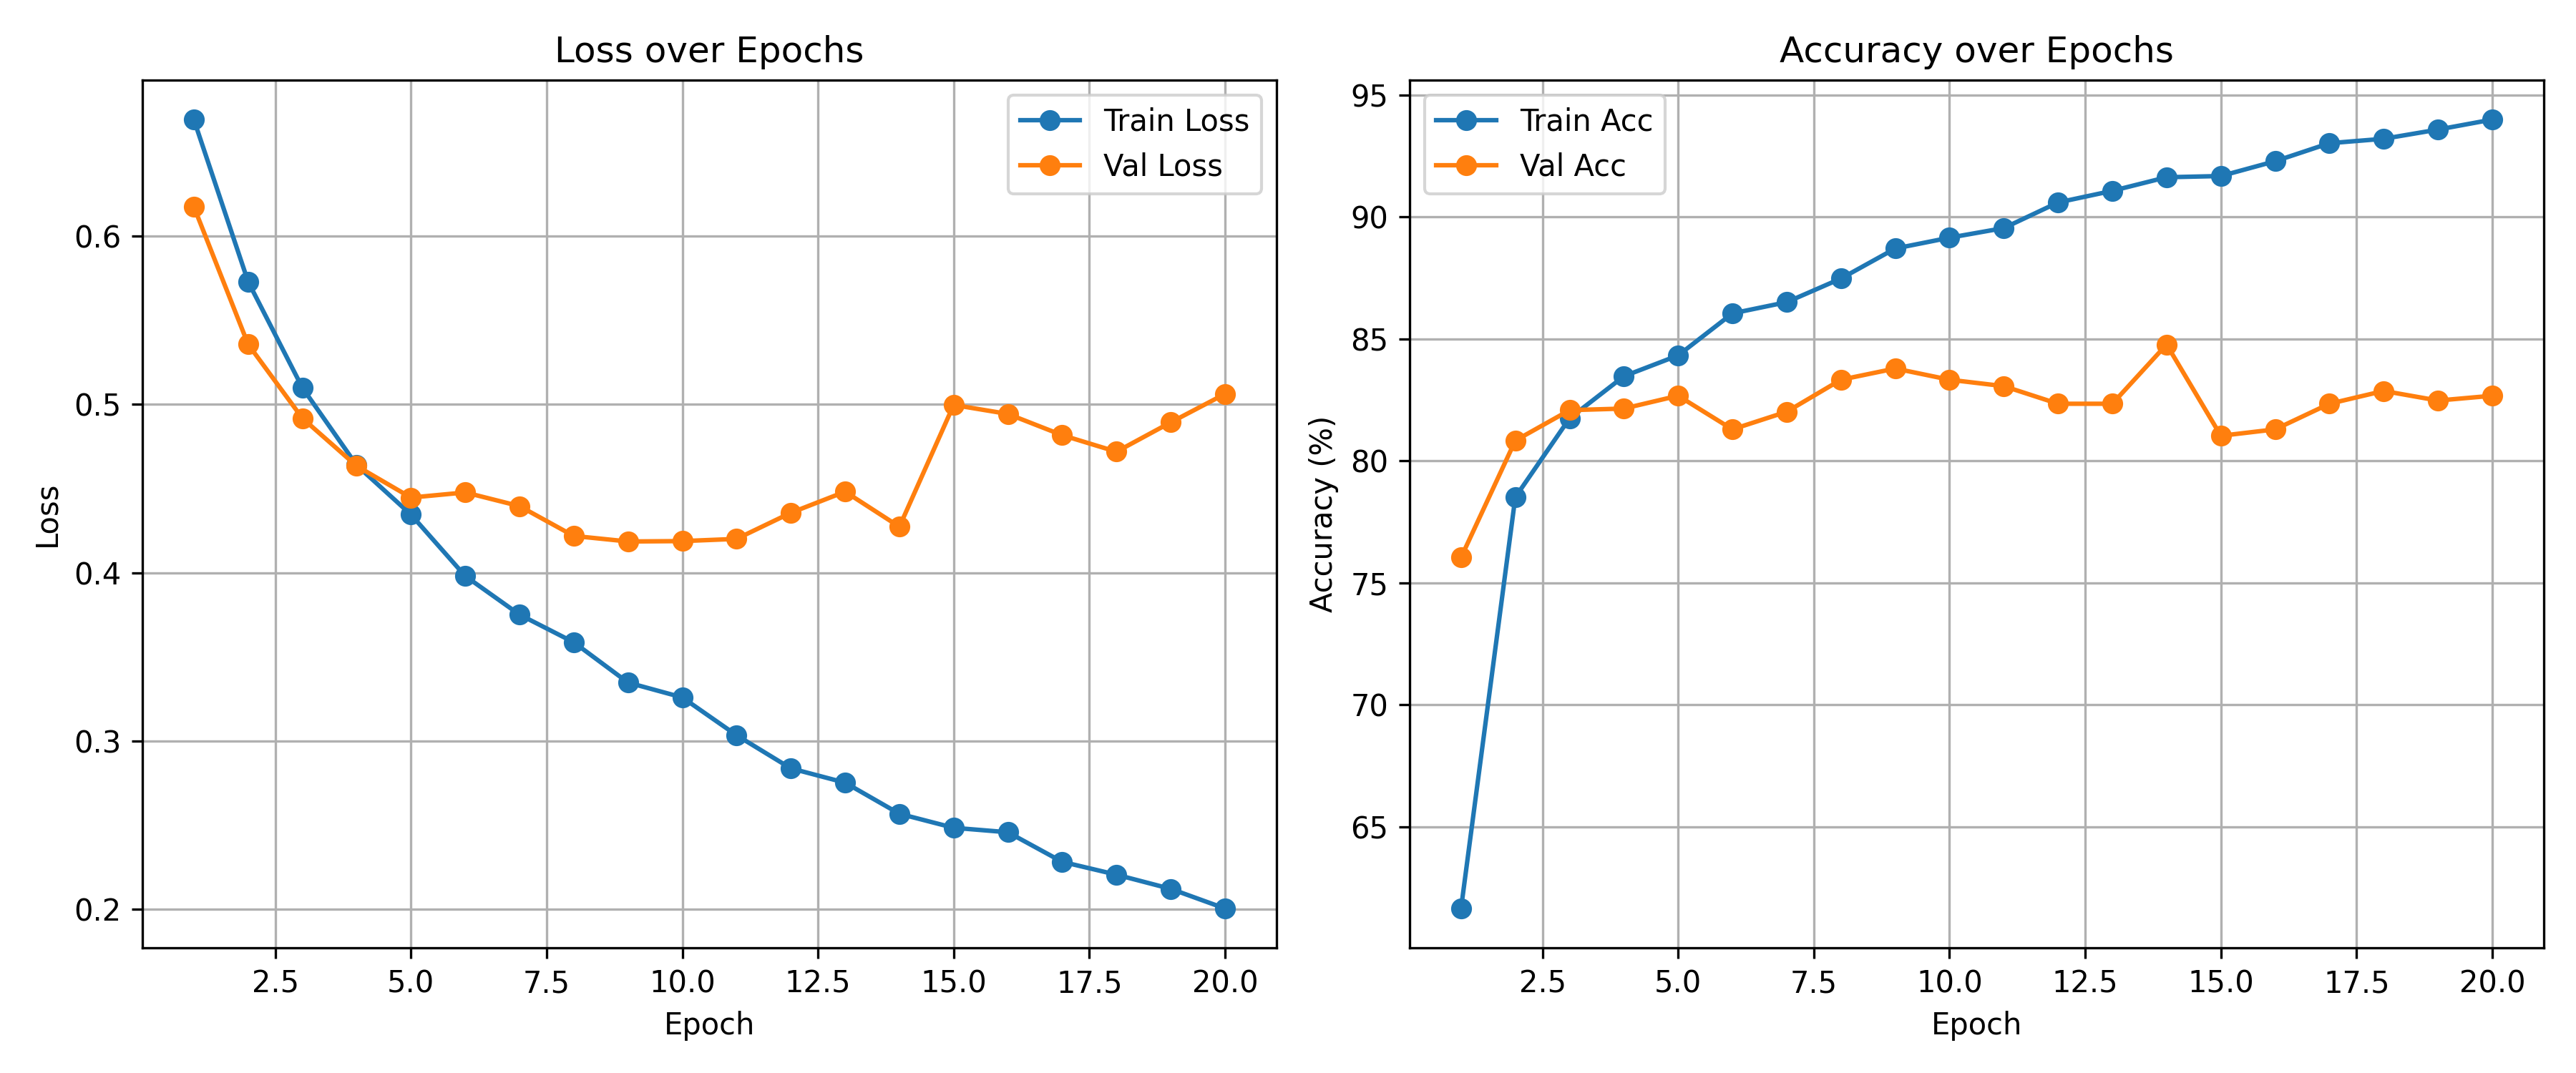 ELECTRA is successful here. Training was performed for up to 20 epochs, but validation loss stopped improving after approximately epoch 10 and began increasing after epoch 12, indicating the onset of overfitting. Validation accuracy also plateaued around 83–85%. Therefore, 12 epochs was selected as an efficient stopping point that balances performance and generalization.

In [ ]:
def valid1(model, validation_loader, device, loss_function):
    model.eval()
    labels = [0, 1]  # for confusion matrix
    n_correct = 0
    tr_loss = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    cm = []

    with torch.no_grad():
        for step, data in tqdm(enumerate(validation_loader, 0)):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)  # Use float for BCEWithLogitsLoss

            logits = model(ids, mask, token_type_ids).logits.squeeze()

            if logits.dim() == 0:
                logits = logits.unsqueeze(0)
                targets = targets.unsqueeze(0)

            loss = loss_function(logits, targets)
            tr_loss += loss.item()

            # Predict using sigmoid + threshold
            preds = (torch.sigmoid(logits) > 0.5).float()

            correct = (preds == targets).sum().item()
            n_correct += correct

            nb_tr_steps += 1
            nb_tr_examples += targets.size(0)

            # For confusion matrix, use int tensors
            cm.append(confusion_matrix(
                targets.cpu().int(), preds.cpu().int(), labels=labels
            ))

            if step % 100 == 0:
                print('Validation steps completed:', nb_tr_steps)

    epoch_loss = tr_loss / nb_tr_steps
    epoch_accu = (n_correct * 100) / nb_tr_examples
    print(f"\nValidation Loss Epoch: {epoch_loss:.4f}")
    print(f"Validation Accuracy Epoch: {epoch_accu:.2f}%")

    # Combine all confusion matrices
    cm = sum(cm)
    recall = np.diag(cm) / np.sum(cm, axis=1, where=(np.sum(cm, axis=1) != 0))
    precision = np.diag(cm) / np.sum(cm, axis=0, where=(np.sum(cm, axis=0) != 0))
    f1 = 2 * (recall * precision) / (recall + precision + 1e-8)

    return epoch_accu, recall, precision, f1, cm


acc1, recall1, precision1, f11, cm = valid1(model, validation_loader, device, loss_function)

print("Accuracy on test data = %0.2f%%" % acc1)
print('Recall')
print(recall1)
print('Average Recall')
print(recall1.mean())
print('Precision')
print(precision1)
print('Average Precision')
print(precision1.mean())
print('F1')
print(f11)
print('Average F1')
print(f11.mean())
print('Confusion Matrix')
print(cm)

Creating a figure to visualize confusion matrix.

In [ ]:
class_names = ['No Disaster', 'Real Disaster']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(f"confusion_matrix_electra_{EPOCHS}epochs.png", dpi=300)


So this model achieves 83.78% validation accuracy with an average F1 score of 0.83. The confusion matrix shows strong performance on non-disaster tweets (recall 0.91), while disaster recall is lower (0.75), indicating the model misses some real disaster cases. Precision for disaster tweets remains high (0.86), meaning predicted disasters are usually correct. It is worth mentioning that the the training dataset shows a moderate class imbalance, with more tweets labeled as No Disaster (class 0) than Real Disaster (class 1). This imbalance is important because models trained on skewed label distributions may become biased toward predicting the majority class. As a result, accuracy alone may overestimate performance, since the model can achieve high accuracy by favoring the more common non-disaster label. This pattern is reflected in our validation results, where recall for the disaster class is lower, indicating that some true disaster tweets are missed. Overall, the model generalizes well but could be improved by increasing sensitivity to disaster-related language.

It should be interesting to see which tweets are confusion our network. We'll use this function to inspect some false positives and false negatives.

In [ ]:
model.eval()

false_positives = []
false_negatives = []

with torch.no_grad():
    for batch in tqdm(validation_loader):
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        targets = batch['targets'].to(device)

        outputs = model(ids, mask, token_type_ids)
        logits = outputs.logits.squeeze()

        # Ensure shape consistency
        if logits.dim() == 0:
            logits = logits.unsqueeze(0)
            targets = targets.unsqueeze(0)

        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        for i in range(len(targets)):
            text = batch['raw_text'][i]
            true = targets[i].item()
            pred = preds[i].item()

            if true == 1.0 and pred == 0.0:
                false_negatives.append((text, true, pred))
            elif true == 0.0 and pred == 1.0:
                false_positives.append((text, true, pred))

# Show examples
print("\n False Positives (predicted 1, but actually 0):")
for text, true, pred in false_positives[:5]:
    print(f"  True: {true}, Pred: {pred} — {text}")

print("\n False Negatives (predicted 0, but actually 1):")
for text, true, pred in false_negatives[:5]:
    print(f"  True: {true}, Pred: {pred} — {text}")



 False Positives (predicted 1, but actually 0):
  True: 0.0, Pred: 1.0 — The Sound of Arson
  True: 0.0, Pred: 1.0 — @PPFA At least they aren't burning buildings and looting stores.
  True: 0.0, Pred: 1.0 — Blood Group  A +ve is associated with Gastric Carcinoma says text book...Another fragile gene in my body....
  True: 0.0, Pred: 1.0 — @MzMandiLynn GM! I pray any attack of the enemy 2 derail ur destiny is blocked by the Lord &amp; that He floods ur life w/heavenly Blessings
  True: 0.0, Pred: 1.0 — So my band Buildings on Fire are playing @bbcintroducing @PurpleTurtleRdg this Wednesday with @GIANTGIANTSOUND https://t.co/ofaN6DkOEZ #rdg

 False Negatives (predicted 0, but actually 1):
  True: 1.0, Pred: 0.0 — ok peace I hope I fall off a cliff along with my dignity
  True: 1.0, Pred: 0.0 — TWIA board approves 5 percent rate hike: The Texas Windstorm Insurance Association (TWIA) Board of Directors v... http://t.co/TWPl0NL8cx
  True: 1.0, Pred: 0.0 — How long O Lord (Study 3)
 The sixth seal opens the events of Revelation 12. The political upheaval in the Roman... http://t.co/GW0CXoOJyV
  True: 1.0, Pred: 0.0 — Aquarium Ornament Wreck Sailing Boat Sunk Ship Destroyer Fish Tank Cave Decor - Full read Û_ http://t.co/kNCm9jC8i9 http://t.co/swviAZSPHk
  True: 1.0, Pred: 0.0 — 11:30BST traffic: A10&gt;Paris A40 Geneva A7 Mons A1 Hamburg A2&gt;Hanover A5 Karlsruhe Gotthard n/b  http://t.co/yoi9tOCxiQ




Examination of misclassified validation examples reveals common failure modes. False positives often contain disaster-related vocabulary such as fire, burning, or attack used metaphorically (e.g., music or religious contexts), causing the model to incorrectly predict a disaster. False negatives frequently occur in tweets that reference real-world incidents indirectly, such as insurance or traffic updates, or in highly ambiguous language without explicit disaster keywords. These results highlight the difficulty of distinguishing literal disaster reports from figurative or context-dependent language in short tweets.

In [ ]:
df_fp = pd.DataFrame(false_positives, columns=["text", "true_label", "predicted_label"])
df_fn = pd.DataFrame(false_negatives, columns=["text", "true_label", "predicted_label"])

df_fp.to_csv(f'false_positives{EPOCHS}.csv', index=False)
df_fn.to_csv(f'false_negatives{EPOCHS}.csv', index=False)

To make our predictions on the test set, we need to apply the same preprocessing that we used on the training data, except that we won't have targets.

In [ ]:
class TestDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.texts = dataframe['text']
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_token_type_ids=True
        )

        return {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'token_type_ids': torch.tensor(inputs['token_type_ids'], dtype=torch.long),
            'raw_text': text
        }

We'll apply the preprocessing and set up our dataloader

In [ ]:
test_dataset = TestDataset(testdata, tokenizer, max_len=MAX_LEN)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

Now we can used the trained model to make predictions on the test data. Although validation accuracy was used for early model selection, Kaggle ranks submissions by F1 score, which balances precision and recall and better reflects performance on disaster tweet detection.

In [ ]:
model.eval()
predictions = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)

        outputs = model(ids, mask, token_type_ids)
        logits = outputs.logits.squeeze()

        if logits.dim() == 0:
            logits = logits.unsqueeze(0)

        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).int().cpu().numpy()

        predictions.extend(preds)

In [ ]:
#Ensuring we have integer predicions
predictions = [int(p) for p in predictions]

submission = pd.DataFrame({
    "id": testdata["id"],
    "target": predictions
})

submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")

| Training Setting / Epochs         | F1 Score (%) |
|----------------------------------|--------------|
| Kaggle Test Set (5 Epochs)       | 82.35%       |
| Kaggle Test Set (8 Epochs)       | 82.26%       |
| Kaggle Test Set (12 Epochs)      | 82.65%       |
| Kaggle Test Set (20 Epochs)      | 81.12%       |
| Validation Set (12 Epochs)       | 79.80%       |

#Conclusion
In this project, we applied modern NLP techniques to the Kaggle Disaster Tweets classification task, where the goal is to distinguish between tweets describing real disasters and tweets using similar language in a benign or metaphorical way. Using a fine-tuned ELECTRA transformer model, we achieved strong performance, with a best Kaggle leaderboard F1 score of approximately 82.65% and a validation F1 score around 79.8%. These results demonstrate that pretrained transformer models are highly effective for short-text classification problems, even with relatively limited labeled training data.

A key learning from this work is the importance of contextual language understanding. Traditional keyword-based approaches would struggle with tweets that use disaster-related terms metaphorically, but ELECTRA’s transformer architecture is able to capture richer semantic meaning. However, error analysis showed that the model still produced false positives when disaster-related vocabulary appeared in non-disaster contexts (such as music, politics, or religion), and false negatives when real disaster tweets lacked obvious keywords or were highly ambiguous. This highlights the inherent difficulty of interpreting short and noisy social media text.

In terms of model development, training beyond roughly 10–12 epochs did not improve generalization and began to introduce overfitting, as validation loss increased while training accuracy continued to rise. Selecting an efficient stopping point was therefore important for balancing performance and computational cost. Additionally, the moderate class imbalance in the dataset likely contributed to lower recall on the disaster class, as the model tended to perform better on the majority “No Disaster” category.

Several improvements could be explored in future work. These include optimizing directly for F1 during training, applying class weighting or threshold tuning to increase disaster recall, incorporating learning rate scheduling, and experimenting with larger pretrained models or ensembling approaches.

Overall, this project shows that transformer-based models like ELECTRA provide a powerful baseline for disaster tweet detection, while also emphasizing the importance of evaluation metrics, dataset imbalance, and careful error analysis when deploying NLP systems in real-world emergency response contexts.

#References


*   https://aws.amazon.com/what-is/nlp/
*   https://huggingface.co/learn/llm-course/en/chapter1/2
*   https://www.coursera.org/articles/natural-language-processing
*   ChatGPT and Gemini




